In [1]:
from defs import *

## The Data

We begin by reading the full database of names, and select the names that fit the criteria outlined in the paper (e.g. the provenance, the time span, etc...).  This brings the names list from 15119 down to 2128 valid names of which 454 are unique.  

In [2]:
c={'gospels_acts_unattested':pd.read_csv('counts_gospels_acts_unattested.csv'),
      'josephus':pd.read_csv('counts_josephus.csv'),
     }

In [3]:
display(c['gospels_acts_unattested'])
display(c['gospels_acts_unattested'][['gospels_acts_unattested','rest']].sum())

,name,gospels_acts_unattested,rest
0,Simon,8,176
1,Joseph,6,165
2,Eleazar,1,134
3,Judah,3,123
4,Yohanan,3,100
...,...,...,...
449,Zohamai,0,1
450,Zomlit,0,1
451,Bartimaeus,1,0
452,Hagaba,1,0


gospels_acts_unattested      53
rest                       2128
dtype: int64

## Function definitions for the simulation

In [4]:
def simulate_texts(source_counts,rest_counts,Nsims=50000,
              distribution='dirichlet'):
    
    from scipy.stats import dirichlet,multinomial,uniform
    from numpy import percentile
    
    rest=np.array(rest_counts)
    source=np.array(source_counts)
    
    rv_all=dirichlet(1+rest)
    f=array(rest).ravel()
    f=f/f.sum()
    
    N=source.sum()
    K=len(source)

    n_all=[]
    for i in tqdm(range(Nsims)):
        if distribution=='dirichlet':
            p=rv_all.rvs().ravel()
        elif distribution=='frequency':
            p=f
        elif distribution=='uniform':
            p=np.ones(K)/K
        else:
            raise ValueError(f"Distribution '{distribution}'' not implemented")

        nn=multinomial(n=N,p=p).rvs().ravel()
        n_all.append(nn)
    n_all=array(n_all)    
    
    
    pl,pm,pu=np.percentile(n_all,[2.5,50,97.5],axis=0)
        
    return pl,pm,pu,n_all


## The Model

We model the texts as being produced by a stochastic process which uses the probabilities for drawing the various names estimated from the all-names data.  When making comparisons to any specific text, we take care to subtract from the all-names set the name-counts for the specific text being compared in order to avoid double-counting.

We first estimate the probability of drawing each name, denoted by $\theta_i$ where $i$ is an index across names. These parameters are determined by the properties of the Multinomial-Dirichlet model for many categories, which is a generalization of the Binomial-Beta model used for two categories.  A useful tutorial on these concepts can be found at [https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/](https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/).  

Prior to observing any data, we assume that all values of $\theta$ are equally likely, which is commonly handled by using a Dirichlet distribution,
$$
\begin{aligned}
p(\{\theta_1, \theta_2, \cdots, \theta_K\}|\{\alpha_1,\alpha_2,\cdots,\alpha_K\})&=\frac{1}{\mathbf{B}(\alpha_1,\alpha_2,\ldots,\alpha_K)}\theta_1^{\alpha_1-1}\theta_2^{\alpha_2-1}\cdots\theta_K^{\alpha_K-1}\\
&\equiv \text{Dir}(\{\theta_1, \theta_2, \cdots, \theta_K\}|\{\alpha_1,\alpha_2,\cdots,\alpha_K\})
\end{aligned}
$$

where we use $\alpha_1=\alpha_2=\cdots=\alpha_K=1$ for the uniform prior.

The likelihood of seeing a certain number of draws of each possibility, $n_1, n_2, \cdots, n_K$ for a total of $N$ draws of names, given the probabilities for drawing each of $K$ possible names, $\theta_1, \theta_2, \cdots, \theta_K$, is expressed by the Multinomial distribution,

$$
p(\{n_1, n_2, \cdots, n_K\}|N,\{\theta_1, \theta_2, \cdots, \theta_K\})=\left(\begin{array}{c}N!\\ n_1!n_2!\cdots n_K!\end{array}\right)\theta_1^{n_1}\theta_2^{n_2}\cdots\theta_K^{n_K}
$$



Using the multinomial distribution as our likelihood and the Dirichlet distribution as our prior, we apply Bayes theorem to get the distribution over $\theta_1, \theta_2, \cdots, \theta_K$.  This will allow us to get the best estimates for the probabilities of generating the name Simon, Joseph, etc... as well as the uncertainty in those estimates based off the all-names data set.  Conveniently, we get an updated Dirichlet distribution for our posterior,

$$
p(\{\theta_1, \theta_2, \cdots, \theta_K\}|\{n_1, n_2, \cdots, n_K\},N) = \text{Dir}(\{\theta_1, \theta_2, \cdots, \theta_K\}|\{x_1+\alpha_1,x_2+\alpha_2,\cdots,x_K+\alpha_K\})
$$

or, in the case all of the $\alpha=1$, we have
$$
p(\{\theta_1, \theta_2, \cdots, \theta_K\}|\{n_1, n_2, \cdots, n_K\},N) = \text{Dir}(\{\theta_1, \theta_2, \cdots, \theta_K\}|\{x_1+1,x_2+1,\cdots,x_K+1\})
$$

The marginal distribution for one name given our full data, $p(\theta_i|\{n_1, n_2, \cdots, n_K\},N)$ follows a Beta distribution, with properties 

$$
p(\theta_i|\{n_1, n_2, \cdots, n_K\},N) = \text{Beta}(\alpha_i+n_i,N+\sum_i \alpha_i - \alpha_i-n_i)
$$

Although the Dirichlet is a multivariate distribution, this marginal distribution allows us to plot the single-name probability estimates and their uncertainties.  

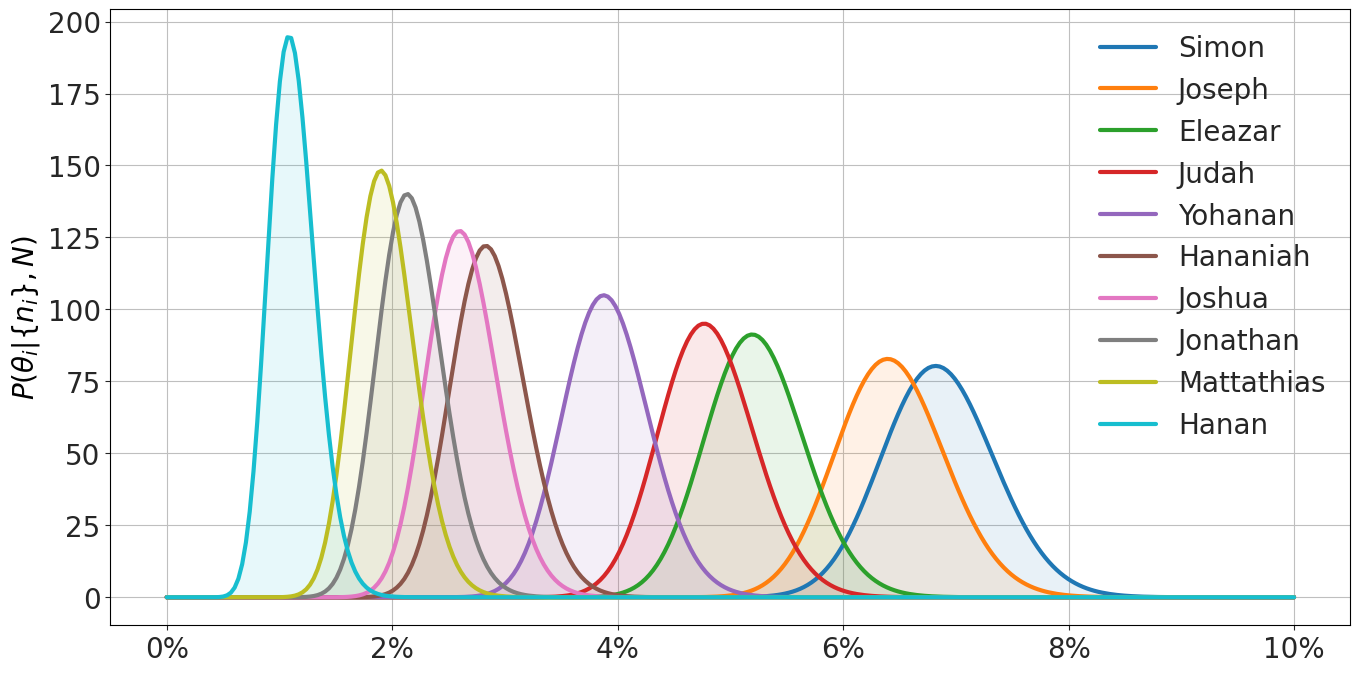

In [5]:
source=c['gospels_acts_unattested']['gospels_acts_unattested']
rest=array(c['gospels_acts_unattested']['rest'])
names=c['gospels_acts_unattested']['name']

n=array(rest)

figure(figsize=(16,8))


α=1+n
N=n.sum()
K=len(n)

K=10
α0=α.sum()
β=α0-α

for idx in range(K):
    p1=D.beta(α[idx],β[idx])
    x=linspace(0,0.1,300)
    #x=np.linspace(p1.ppf(.0001),p1.ppf(.9999),300)
    plot(x*100,p1.pdf(x),'-',color=colors[idx],label=names[idx])
    fill_between(x*100,p1.pdf(x),alpha=0.1,color=colors[idx])
    
    mode=n[idx]/(K-2+N)
    mode=(α[idx]-1)/(α[idx]+β[idx]-2)    
    
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
mxticks = mtick.FormatStrFormatter(fmt)
gca().xaxis.set_major_formatter(mxticks)

ylabel(r"$P(\theta_i|\{n_i\},N)$")
    
legend();

## Simulating the Document Name Counts

Once we have the posterior probabilities, $p(\{\theta_1, \theta_2, \cdots, \theta_K\}|\{n_1, n_2, \cdots, n_K\},N)$,  for the name fractions in the all-names set, we can simulate the name-counts for a document with a specific total number of names by drawing randomly from the all-names data.  In this way we can compare how similar any text is to the full data set by comparing the simulated texts with the texts we actually have.  The process takes several steps,

1. draw a random set of name probabilities $\{\theta_i\}$ from the Dirichlet posterior estimated from the all-names data
2. from those $\{\theta_i\}$, draw a sample of names of size $N_j$, where $j$ is the index for the type of document (e.g. Gospels-Acts, Josephus, etc...)
3. repeat this sampling many times
4. compare the actual source data counts with the simulated counts, and flag anything outside of the 95% percentile range as being not consistent

In [6]:
def draw_random_θ(n,number_of_draws=10):
    rv_all=dirichlet(1+n)
    θ=[]
    for i in range(number_of_draws):
        θ.append(rv_all.rvs().ravel())
    θ=pd.DataFrame(θ)
    θ.columns=names[:len(n)]
    return θ


def draw_random_n(θ,N,number_of_draws=10):
    
    n_all=[]
    for i,θrow in θ.iterrows():
        p=array(θrow)
        nn=multinomial(n=N,p=p).rvs().ravel()
        n_all.append(nn)
        
    n_all=pd.DataFrame(n_all)
    n_all.columns=θ.columns

    return n_all

pd.set_option('display.max_columns', 16)    

In [7]:
pd.set_option('display.max_columns', 8)
pd.set_option("display.precision", 3)

θ=draw_random_θ(n)
display(HTML("<h3>Step 1: random set of  {𝜃𝑖}  from the Dirichlet posterior</h3>"))
θ

name,Simon,Joseph,Eleazar,Judah,...,Zomlit,Bartimaeus,Hagaba,Timaius
0,0.062,0.066,0.054,0.058,...,7.705e-04,7.359e-05,9.125e-04,2.606e-04
1,0.061,0.067,0.051,0.053,...,6.020e-04,7.267e-04,2.271e-04,4.773e-04
2,0.064,0.071,0.054,0.052,...,2.659e-04,3.517e-05,5.286e-04,4.486e-06
3,0.063,0.064,0.052,0.051,...,1.454e-03,1.248e-03,4.497e-04,2.877e-04
4,0.074,0.068,0.045,0.041,...,1.323e-03,6.889e-05,2.555e-04,6.054e-04
5,0.071,0.062,0.044,0.047,...,4.386e-04,1.606e-04,2.270e-04,5.721e-04
6,0.080,0.066,0.044,0.051,...,7.310e-04,2.277e-05,1.322e-03,1.964e-04
7,0.072,0.055,0.049,0.046,...,7.619e-05,5.870e-04,8.259e-05,1.400e-04
8,0.077,0.062,0.052,0.043,...,7.135e-04,1.366e-04,5.762e-05,1.356e-04
9,0.070,0.065,0.049,0.050,...,9.904e-04,5.260e-04,6.863e-04,1.256e-04


In [8]:
pd.set_option('display.max_columns', 8)
pd.set_option("display.precision", 3)

display(HTML("<h3>Step 2: from those  {𝜃𝑖} , draw a sample of names of size  𝑁𝑗 , where  𝑗  is the index for the type of document (e.g. Gospels-Acts, Josephus, etc...)</h3>"))

draw_random_n(θ,c['gospels_acts_unattested']['gospels_acts_unattested'].sum())

name,Simon,Joseph,Eleazar,Judah,...,Zomlit,Bartimaeus,Hagaba,Timaius
0,5,4,2,2,...,0,0,0,0
1,4,3,1,3,...,0,1,0,0
2,3,5,2,2,...,0,0,0,0
3,2,4,4,4,...,0,1,0,0
4,3,2,3,1,...,0,0,0,0
5,2,3,1,2,...,0,0,1,0
6,7,2,7,2,...,1,0,0,0
7,2,1,8,2,...,0,0,0,0
8,7,6,2,2,...,0,0,0,0
9,4,2,0,1,...,0,0,0,0


Using this method it is easy to see both the document-to-document variation and the name-to-name variation.  The variation for both is high given the low numbers of occurrences of any given name.

In [9]:
def make_plot(document,Nsims=50000,α=1):
    from tqdm import tqdm
    
    source_counts=c[document][document]
    rest_counts=array(c[document]['rest'])
    names=c[document]['name']

    names_arr=array(names)
    
    rest=np.array(rest_counts)
    source=np.array(source_counts)
    
    rv_all=dirichlet(α+rest)
    f=array(rest).ravel()
    f=f/f.sum()
    
    N=source.sum()
    K=len(source)

    n_all=[]
    for i in tqdm(range(Nsims)):
        p=rv_all.rvs().ravel()
        nn=multinomial(n=N,p=p).rvs().ravel()
        n_all.append(nn)
    n_all=array(n_all)    
    
    
    pl,pm,pu=np.percentile(n_all,[2.5,50,97.5],axis=0)
        
    count=0
    step=6
    
    names_outside=list(names_arr[((source>pu) | (source<pl))])  
    
    figure(figsize=(16,8))
    plot(pl-.1,'^k',ms=6)
    plot(pu+.1,'vk',ms=6)

    docs=['all','gospels_acts_unattested', 'josephus','rabbinic','ossuary','literary','scroll','talmud_jerusalem','talmud_babylonian',
       'other' ]
    plot(source,'o',color=colors[docs.index(document)],ms=6)

    max_name_idx=25
    xl=xlim([-.5,max_name_idx-0.5])
    
    
    xticks(range(max_name_idx),names_arr[:max_name_idx],rotation=90);        
    title(document)
    
    yl=ylim()
    text(max_name_idx*.8,yl[1]*.95,'Names outside of 95% interval',ha='center',size=20)
    text(max_name_idx*.8,yl[1]*0.9,"\n".join(names_outside),va='top',ha='center',size=20)


    plt.show()
    plt.close(gcf())
        
    
    return pl,pm,pu,source,rest,names_outside

100%|████████████████████████████████| 100000/100000 [00:04<00:00, 21541.84it/s]


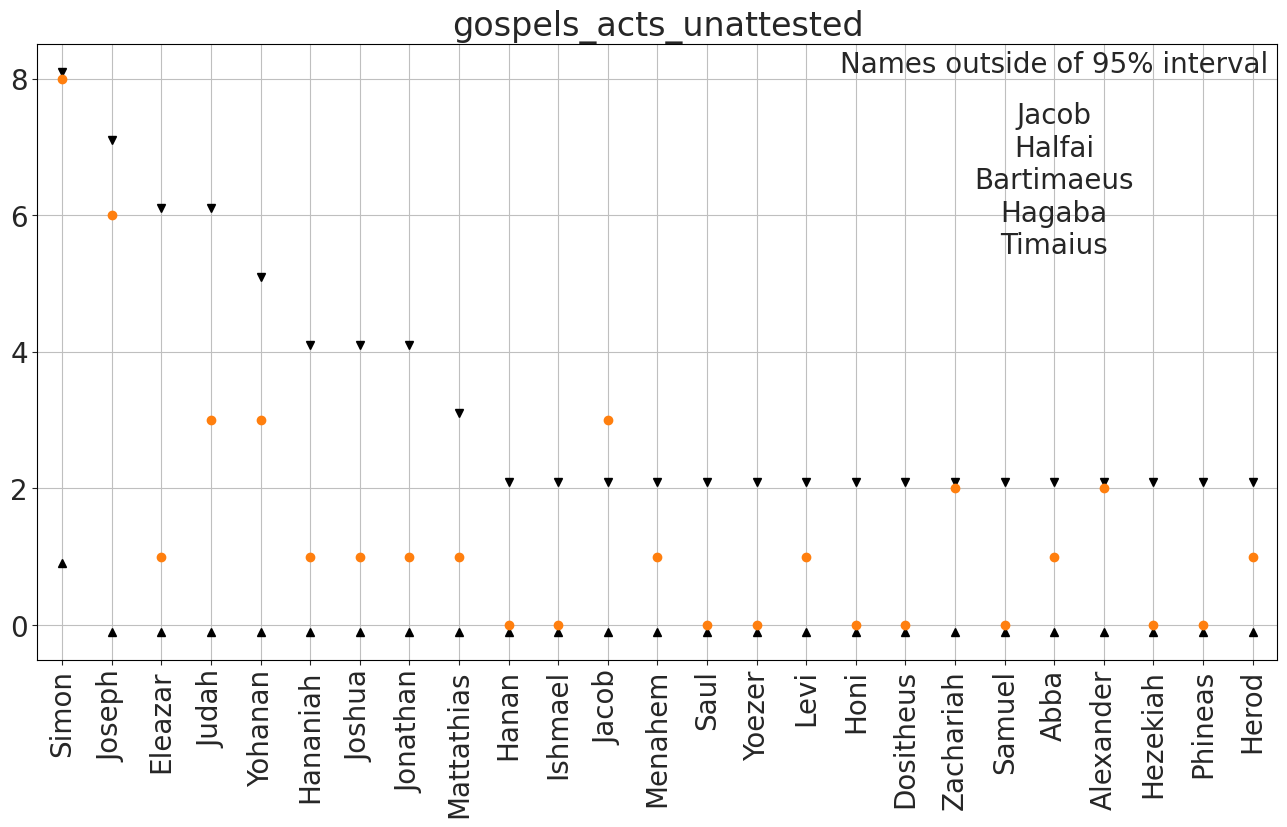

In [10]:
pl,pm,pu,source,rest,names_outside=make_plot('gospels_acts_unattested',Nsims=100000);

100%|████████████████████████████████| 100000/100000 [00:04<00:00, 20156.47it/s]


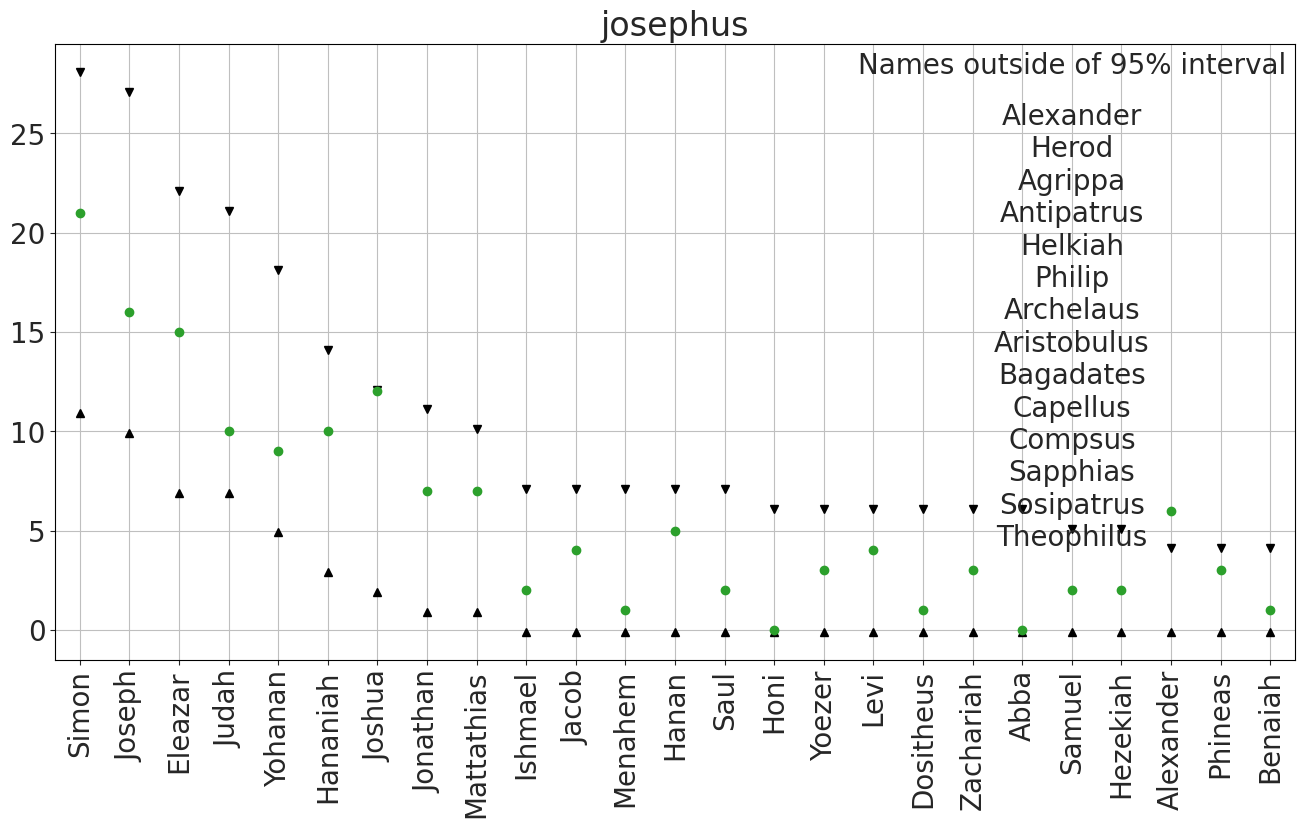

In [11]:
pl,pm,pu,source,rest,names_outside=make_plot('josephus',Nsims=100000);

In [12]:
document='gospels_acts_unattested'
source_counts=c[document][document]
rest_counts=array(c[document]['rest'])
names=c[document]['name']
names_arr=array(names)

pl,pm,pu,n_all=simulate_texts(source_counts,rest_counts,Nsims=50000,distribution='dirichlet')
plu,pmu,puu,n_allu=simulate_texts(source_counts,rest_counts,Nsims=50000,distribution='uniform')


100%|██████████████████████████████████| 50000/50000 [00:01<00:00, 28568.10it/s]


['Jacob', 'Halfai', 'Bartimaeus', 'Hagaba', 'Timaius']

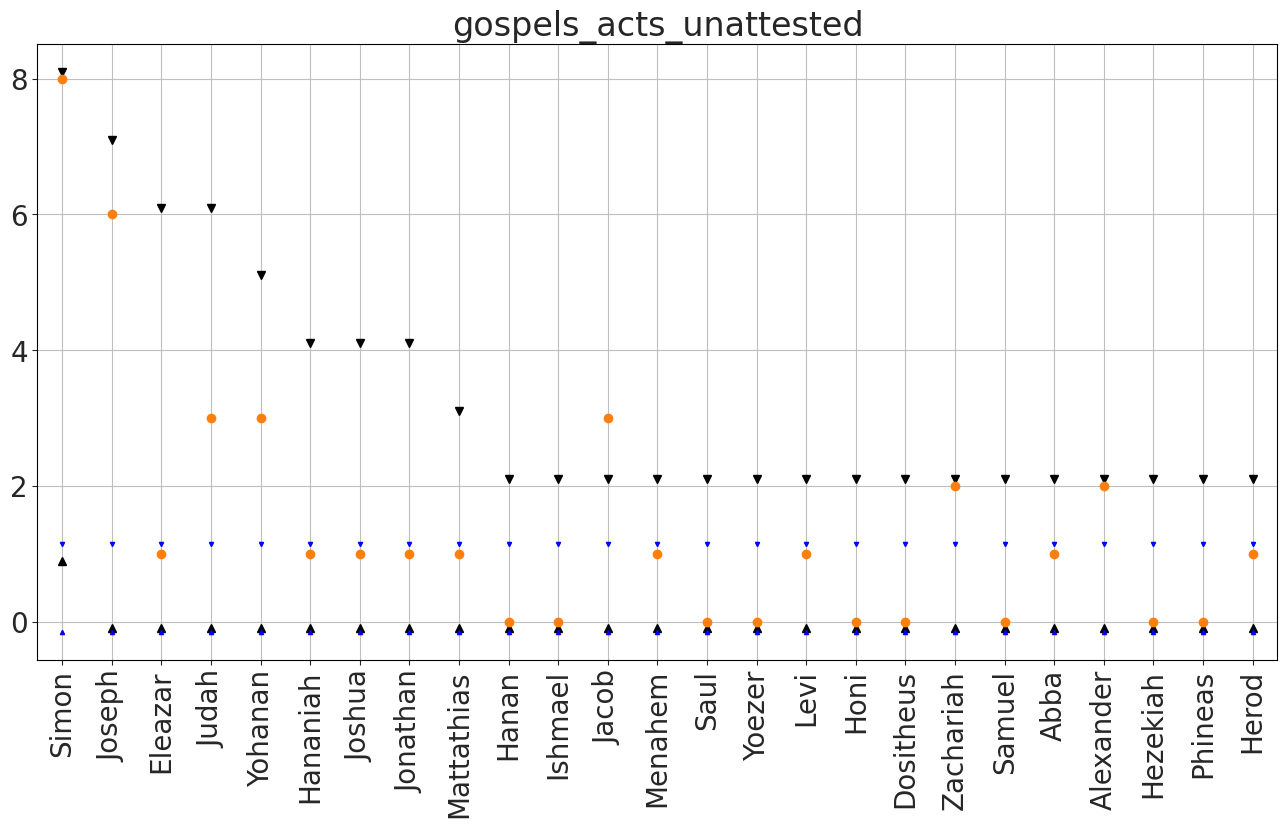

In [13]:
figure(figsize=(16,8))
plot(pl-.1,'^k',ms=6)
plot(pu+.1,'vk',ms=6)
plot(source_counts,'o',color=colors[docs.index(document)],ms=6)
max_name_idx=25
xl=xlim([-.5,max_name_idx-0.5])

plot(puu+.15,'vb',ms=3)
plot(plu-.15,'^b',ms=3)

xticks(range(max_name_idx),names_arr[:max_name_idx],rotation=90);        
title(document)

names_outside=list(names_arr[((source_counts>pu) | (source_counts<pl))])  
names_outside



In [14]:
document='josephus'
source_counts=c[document][document]
rest_counts=array(c[document]['rest'])
names=c[document]['name']
names_arr=array(names)

pl,pm,pu,n_all=simulate_texts(source_counts,rest_counts,Nsims=50000,distribution='dirichlet')
plu,pmu,puu,n_allu=simulate_texts(source_counts,rest_counts,Nsims=50000,distribution='uniform')


100%|██████████████████████████████████| 50000/50000 [00:02<00:00, 24574.06it/s]


['Alexander',
 'Herod',
 'Agrippa',
 'Antipatrus',
 'Helkiah',
 'Philip',
 'Archelaus',
 'Aristobulus',
 'Bagadates',
 'Capellus',
 'Compsus',
 'Sapphias',
 'Sosipatrus',
 'Theophilus']

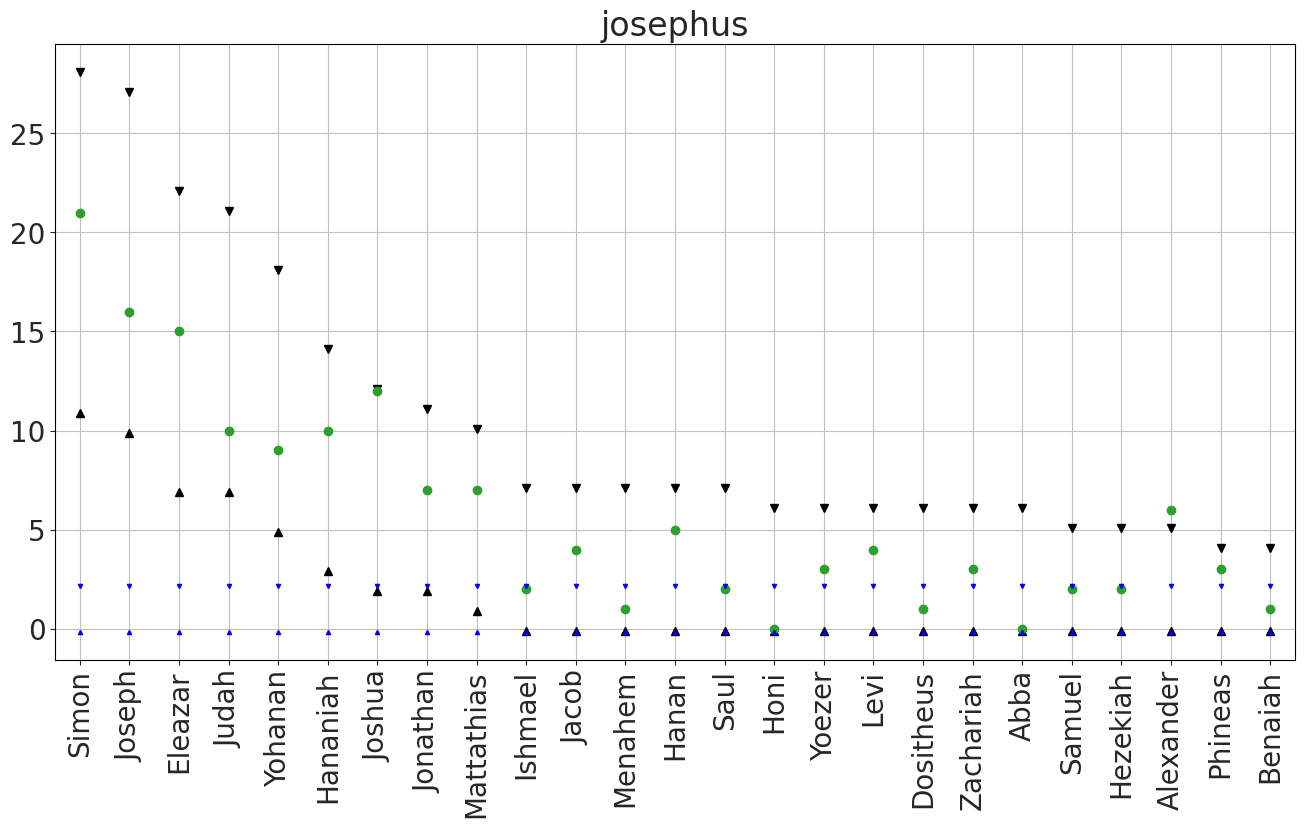

In [15]:
figure(figsize=(16,8))
plot(pl-.1,'^k',ms=6)
plot(pu+.1,'vk',ms=6)
plot(source_counts,'o',color=colors[docs.index(document)],ms=6)
max_name_idx=25
xl=xlim([-.5,max_name_idx-0.5])

plot(puu+.15,'vb',ms=3)
plot(plu-.15,'^b',ms=3)

xticks(range(max_name_idx),names_arr[:max_name_idx],rotation=90);        
title(document)

names_outside=list(names_arr[((source_counts>pu) | (source_counts<pl))])  
names_outside

